# 优达学城P3（安然公司邮件数据分析）

## 1 数据概况

### 1.1 载入数据

In [1]:
#!/usr/bin/python
# -*- coding=utf-8 -*-
import sys
import pickle

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from tester import test_classifier
import pandas as pd
import matplotlib.pyplot as plt

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                 'to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                 'shared_receipt_with_poi']  # You will need to use more features
my_dataset = data_dict

### 1.2 观察空值
横向观察数据缺失情况

In [2]:
data_df = pd.DataFrame(data_dict)
people=data_df.columns
nandict={}
for p in people:
    if 'NaN' in data_df[p].unique():
        nandict[p]=data_df[p].value_counts()['NaN']
print sorted(nandict.items(), lambda x, y: cmp(x[1], y[1]), reverse=True)
data_df.drop('LOCKHART EUGENE E',axis=1,inplace=True)

[('LOCKHART EUGENE E', 20), ('WHALEY DAVID A', 18), ('WROBEL BRUCE', 18), ('THE TRAVEL AGENCY IN THE PARK', 18), ('GRAMM WENDY L', 18), ('WODRASKA JOHN', 17), ('CLINE KENNETH W', 17), ('WAKEHAM JOHN', 17), ('SCRIMSHAW MATTHEW', 17), ('GILLIS JOHN', 17), ('SAVAGE FRANK', 17), ('LOWRY CHARLES P', 16), ('CHAN RONNIE', 16), ('URQUHART JOHN A', 16), ('MENDELSOHN JOHN', 16), ('MEYER JEROME J', 16), ('GATHMANN WILLIAM D', 16), ('PEREIRA PAULO V. FERRAZ', 16), ('BLAKE JR. NORMAN P', 16), ('CHRISTODOULOU DIOMEDES', 16), ('WINOKUR JR. HERBERT S', 16), ('YEAP SOON', 16), ('FUGH JOHN L', 16), ('WALTERS GARETH W', 15), ('DUNCAN JOHN H', 15), ('LEMAISTRE CHARLES', 15), ('GRAY RODNEY', 15), ('NOLES JAMES L', 15), ('BADUM JAMES P', 15), ('BELFER ROBERT', 14), ('PRENTICE JAMES', 14), ('BERBERIAN DAVID', 13), ('BAZELIDES PHILIP J', 13), ('JAEDICKE ROBERT', 13), ('HIRKO JOSEPH', 13), ('MORDAUNT KRISTINA M', 12), ('PIRO JIM', 12), ('LEWIS RICHARD', 12), ('POWERS WILLIAM', 12), ('KISHKILL JOSEPH G', 12), (

LOCKHART EUGENE E所有特征都为空，删除该数据。

纵向观察数据空值情况

In [3]:
data_df = data_df.T
data_df = data_df[features_list]
for f in features_list:
    if 'NaN' in data_df[f].unique():
        print 'There are %s null values in %s' % (str(data_df[f].value_counts()['NaN']), f)

There are 50 null values in salary
There are 106 null values in deferral_payments
There are 20 null values in total_payments
There are 141 null values in loan_advances
There are 63 null values in bonus
There are 127 null values in restricted_stock_deferred
There are 96 null values in deferred_income
There are 19 null values in total_stock_value
There are 50 null values in expenses
There are 43 null values in exercised_stock_options
There are 52 null values in other
There are 79 null values in long_term_incentive
There are 35 null values in restricted_stock
There are 128 null values in director_fees
There are 59 null values in to_messages
There are 34 null values in email_address
There are 59 null values in from_poi_to_this_person
There are 59 null values in from_messages
There are 59 null values in from_this_person_to_poi
There are 59 null values in shared_receipt_with_poi


deferral_payments、loan_advances、restricted_stock_deferred、director_fees四个变量空值较多，可以忽略；email_address这个变量为字符型变量，无法进行计算，也可忽略。将其他变量的空值用0替换。
### 1.3 转换为DataFrame格式  
在DataFrame中填充空值为0

In [4]:
data_df=data_df[features_list]
data_df.replace({'NaN': 0}, inplace=True)

## 2 去除异常值

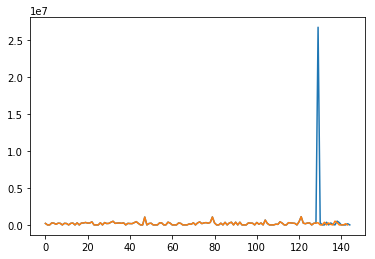

In [5]:
plt.plot(list(data_df['salary'].values))
data_df = data_df[data_df['salary'] < 2e7]#删除异常值所在数据行
plt.plot(list(data_df['salary'].values))
plt.show()

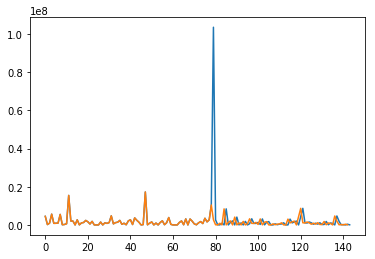

In [6]:
plt.plot(list(data_df['total_payments'].values))
data_df = data_df[data_df['total_payments'] < 1e8]#删除异常值所在数据行
plt.plot(list(data_df['total_payments'].values))
plt.show()

变量分布

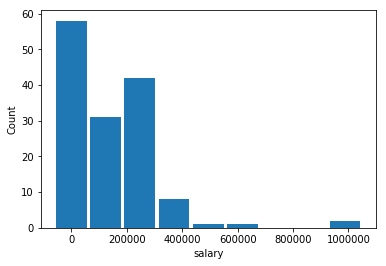

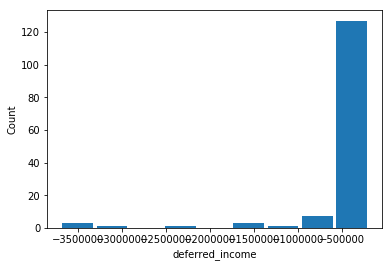

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def make_hist(data,feature_name,bins):
    min_data=data[feature_name].values.min()
    max_data=data_df[feature_name].values.max()
    hist,bin_edges=np.histogram(data[feature_name].values,bins=np.linspace(min_data,max_data,bins))
    plt.bar(bin_edges[:-1],hist,width=float(max_data-min_data)/bins)
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.show()
make_hist(data_df,'salary',10)
make_hist(data_df,'deferred_income',10)

In [8]:
print data_df['poi'].describe()

count       143
unique        2
top       False
freq        126
Name: poi, dtype: object


去除异常值和空值以后，共有143条数据，其中poi为True有17个，poi为False有126个。可以看出数据分布不均衡，正样本占比为11.89%，因此在建模和交叉验证阶段要使用分层抽样，模型评价中，要选择recall和precision或f1score。

## 3 设计新特征  
从原有特征中演变出两个新的变量，最终使用了17个特征

In [9]:
#print data_df.describe()
data_df['from_poi_ratio'] = (data_df['from_poi_to_this_person'] / data_df['to_messages']).fillna(0)
data_df['to_poi_ratio'] = (data_df['from_this_person_to_poi'] / data_df['from_messages']).fillna(0)

In [10]:
my_features = ['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value',
               'expenses', 'exercised_stock_options', 'other',
               'long_term_incentive', 'restricted_stock', 'to_messages', 'from_poi_to_this_person', 'from_messages',
               'from_this_person_to_poi', 'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio']
labels = data_df[my_features[0]].values
features = data_df[my_features[1:]].values

## 4 尝试算法  
使用SelectKBest挑选变量，并得出每个变量的得分,根据重要性得分挑选最终变量。

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

scaler = StandardScaler()

data_select=SelectKBest(k=10).fit(features,labels)
print my_features[1:]
print data_select.scores_

['salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio']
[  1.23815616e+01   1.74217130e+00   1.39542854e+01   1.18497814e+01
   1.63125076e+01   4.97016273e+00   1.68003518e+01   6.53156972e-03
   5.23275955e+00   3.31485544e+00   1.05638708e+00   4.42830698e+00
   1.31732482e-01   2.61649395e+00   7.08626103e+00   3.21442217e+00
   1.40800024e+01]


从中可以看出other、from_messages这两个变量的重要性相对较低，剔除这两个变量。

In [12]:
my_features = ['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value',
               'expenses', 'exercised_stock_options',
               'long_term_incentive', 'restricted_stock', 'to_messages', 'from_poi_to_this_person',
               'from_this_person_to_poi', 'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio']

朴素贝叶斯

In [13]:
#pipe_gnb = Pipeline(steps=[('scaler', scaler), ('pca', PCA()), ('clf', GaussianNB())])
pipe_gnb = Pipeline(steps=[('scaler', scaler), ('skb', SelectKBest()), ('clf', GaussianNB())])
test_classifier(pipe_gnb, labels, features, my_features)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('skb', SelectKBest(k=10, score_func=<function f_classif at 0x000000001AF433C8>)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.80613	Precision: 0.28215	Recall: 0.29400	F1: 0.28795	F2: 0.29155
	Total predictions: 15000	True positives:  588	False positives: 1496	False negatives: 1412	True negatives: 11504



在没有调整任何参数情况下，朴素贝叶斯的预测情况为accuracy为80.6%，precision=28.215%,recall=29.4%,f1=28.795%

SVC

In [15]:
# SVC
pipe_svc = Pipeline(steps=[('scaler', scaler), ('pca', PCA()), ('clf', SVC())])
test_classifier(pipe_svc, labels, features, my_features)

Got a divide by zero when trying out: Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Precision or recall may be undefined due to a lack of true positive predicitons.


逻辑回归

In [16]:
# 逻辑回归
pipe_lr = Pipeline(steps=[('scaler', scaler), ('pca', PCA()), ('clf', LogisticRegression())])
test_classifier(pipe_lr, labels, features, my_features)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.84047	Precision: 0.30978	Recall: 0.16000	F1: 0.21101	F2: 0.17713
	Total predictions: 15000	True positives:  320	False positives:  713	False negatives: 1680	True negatives: 12287



在没有调整任何参数情况下，朴素贝叶斯的预测情况为accuracy为84.047%，precision=30.978%,recall=16%,f1=21.1%

## 5 优化模型

朴素贝叶斯  
使用SelectKBest挑选出最优特征进入模型

In [14]:
print 'GaussianNB:'
pipe_gnb = Pipeline(steps=[('skb', SelectKBest()), ('clf', GaussianNB())])
param_grid = {'skb__k': range(10, 15)}
gs = GridSearchCV(pipe_gnb, param_grid=param_grid)
gs.fit(features, labels)
print gs.best_params_, gs.best_score_

pipe_gnb.set_params(skb__k=gs.best_params_['skb__k'])
test_classifier(pipe_gnb, labels, features, my_features)

GaussianNB:
{'skb__k': 11} 0.825174825175
Pipeline(steps=[('skb', SelectKBest(k=11, score_func=<function f_classif at 0x000000001AF433C8>)), ('clf', GaussianNB(priors=None))])
	Accuracy: 0.83647	Precision: 0.37239	Recall: 0.33050	F1: 0.35020	F2: 0.33811
	Total predictions: 15000	True positives:  661	False positives: 1114	False negatives: 1339	True negatives: 11886



最优参数为11个变量，最终的结果accuracy为82.5%，precision=37.239%,recall=33.05%,f1=35.02%

SVC

In [15]:
print 'SVC:'
pipe_svc = Pipeline(steps=[('scaler', scaler), ('pca', PCA()), ('clf', SVC())])
param_grid = {'pca__n_components': range(1,10), 'clf__kernel': ['linear', 'rbf'], 'clf__C': [0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
gs = GridSearchCV(pipe_svc, param_grid=param_grid, cv=cv)
gs.fit(features, labels)
print gs.best_params_, gs.best_score_

pipe_svc.set_params(pca__n_components=2)
test_classifier(pipe_svc, labels, features, my_features)

{'pca__n_components': 8, 'clf__C': 0.1, 'clf__kernel': 'linear'} 0.888372093023
Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86400	Precision: 0.08333	Recall: 0.00200	F1: 0.00391	F2: 0.00249
	Total predictions: 15000	True positives:    4	False positives:   44	False negatives: 1996	True negatives: 12956



逻辑回归

In [17]:
print 'LogisticRegression:'
pipe_lr = Pipeline(steps=[('scaler', scaler), ('pca', PCA()), ('clf', LogisticRegression())])
param_grid = [{'pca__n_components': range(1, 10)}]
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
gs = GridSearchCV(pipe_lr, param_grid=param_grid, cv=cv)
gs.fit(features, labels)

print gs.best_params_, gs.best_score_

pipe_svc.set_params(pca__n_components=6)
test_classifier(pipe_lr, labels, features, my_features)

LogisticRegression:
{'pca__n_components': 1} 0.86976744186
Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.84047	Precision: 0.30978	Recall: 0.16000	F1: 0.21101	F2: 0.17713
	Total predictions: 15000	True positives:  320	False positives:  713	False negatives: 1680	True negatives: 12287



最优参数为PCA聚类成1个变量，最终的结果accuracy为84.047%，precision=30.978%,recall=16%,f1=21.1%

由于该数据集存在较大不平衡性，因此在模型评估中使用了分层抽样，最终选取precision和recall较高的算法为最好结果，从以上结果比较可以看出，GaussianNB算法的结果最好。

In [17]:
dump_classifier_and_data(pipe_gnb, my_dataset, features_list)